In [1]:
import pandas as pd
df = pd.read_table("guillaume.txt", sep=";")
df.head()

C:\Users\spica\AppData\Local\Temp\ipykernel_13764\2198844990.py:2: DtypeWarning: Columns (1,2,5,6,7,8,9,15,16,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table("guillaume.txt", sep=";")


,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,...,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure
0,A013010004908126703060931,78643044,0,20,2017-02-01 07:32:14,1,0,0,0,551,...,"37,186667890919111","52,076033757361408",0,1,4,4,4,20,0,27134
1,A013011306908024927155000,78643045,0,20,2017-02-01 07:43:37,1,0,0,0,551,...,"48,844716275908937","52,076033757361408",1,2,"1,7976851851851852",4,4,"28,609999999999999","8,6099999999999994",27817
2,A013010002908283134592527,78643046,0,"57,640000000000001",2017-02-01 07:47:38,1,0,0,0,549,...,"73,118279569892479","52,076033757361408",0,1,4,4,4,"57,640000000000001",0,28058
3,A011010002908105209831316,78643047,0,"54,289999999999999",2017-02-01 07:48:48,0,1,1,1,267,...,"110,05692599620494","53,554233554497365",0,1,4,4,4,"54,289999999999999",0,28128
4,A013010041908000125652029,78643048,0,"26,899999999999999",2017-02-01 08:13:27,1,0,0,0,549,...,"45,36831264567185","52,076033757361408",1,1,"1,9971064814814814",4,4,"59,149999999999999","32,25",29607


# Nettoyage 

On supprime la ligne 1956360 qui comporte comme valeur pour chaque colonne l'en-tête

In [2]:
df.drop(1956360, axis=0, inplace=True)

On change le type des variables quantitatives

In [3]:
var_quanti = ["Montant","VerifianceCPT1","VerifianceCPT2","VerifianceCPT3","D2CB","ScoringFP1","ScoringFP2","ScoringFP3","TauxImpNb_RB","TauxImpNB_CPM","NbrMagasin3J","DiffDateTr1","DiffDateTr2","DiffDateTr3","CA3TRetMtt","CA3TR","EcartNumCheq"]
new_df=df
for i in var_quanti:
    new_df[i] = df[i].str.replace(",",".")
    new_df[i] = pd.to_numeric(df[i], downcast="float")

In [6]:
import datetime  

date = []
heure = []


for i in new_df["DateTransaction"]:
    split = i.split(" ")
    date.append(split[0])
    heure.append(split[1])

for i in range(0,len(date)):
    date[i] = datetime.datetime.strptime(date[i], '%Y-%m-%d')



In [7]:
new_df["DateTransaction"]=date
new_df["Heure"]=heure

On s'occupe des des valeurs manquantes 

In [9]:
print(len(new_df.VerifianceCPT1))

4646773


In [8]:
print(new_df.isna().sum())

ZIBZIN                            0
IDAvisAutorisationCheque          0
FlagImpaye                        0
Montant                           0
DateTransaction                   0
CodeDecision                      0
VerifianceCPT1              4614006
VerifianceCPT2              4614006
VerifianceCPT3              4614006
D2CB                        4614006
ScoringFP1                        0
ScoringFP2                        0
ScoringFP3                        0
TauxImpNb_RB                      0
TauxImpNB_CPM                     0
EcartNumCheq                4614006
NbrMagasin3J                4614006
DiffDateTr1                       0
DiffDateTr2                       0
DiffDateTr3                       0
CA3TRetMtt                        0
CA3TR                             0
Heure                             0
dtype: int64


Beaucoup trop de valeurs manquantes donc on vire les colonnes

In [12]:
#new_df = new_df.drop(columns=["VerifianceCPT1","VerifianceCPT2","VerifianceCPT3","EcartNumCheq","NbrMagasin3J","D2CB"])
print(new_df.isna().sum())

ZIBZIN                      0
IDAvisAutorisationCheque    0
FlagImpaye                  0
Montant                     0
DateTransaction             0
CodeDecision                0
ScoringFP1                  0
ScoringFP2                  0
ScoringFP3                  0
TauxImpNb_RB                0
TauxImpNB_CPM               0
DiffDateTr1                 0
DiffDateTr2                 0
DiffDateTr3                 0
CA3TRetMtt                  0
CA3TR                       0
Heure                       0
dtype: int64


On nettoie la colonne FlagImpaye

In [36]:
new_df.FlagImpaye=new_df.FlagImpaye.replace(0,"0")
new_df.FlagImpaye=new_df.FlagImpaye.replace(1,"1")

On crée les dataframe train et test 

In [37]:
train_df=new_df[(new_df["DateTransaction"]>='2017-02-01') & (new_df["DateTransaction"]<='2017-08-31')]
test_df=new_df[(new_df["DateTransaction"]>'2017-08-31')]

In [38]:
Y_train = train_df.FlagImpaye
Y_test = test_df.FlagImpaye
X_train = train_df.drop(columns=["FlagImpaye","ZIBZIN","IDAvisAutorisationCheque","CodeDecision","DateTransaction","Heure"])
X_test = test_df.drop(columns=["FlagImpaye","ZIBZIN","IDAvisAutorisationCheque","CodeDecision","DateTransaction","Heure"])

# MACHINE LEARNING

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

Création du modèle

In [41]:
model_arbre = DecisionTreeClassifier(max_depth=3 ,
                                 min_samples_leaf=10,
                                 min_samples_split=20)
model_arbre = model_arbre.fit(X_train,Y_train)

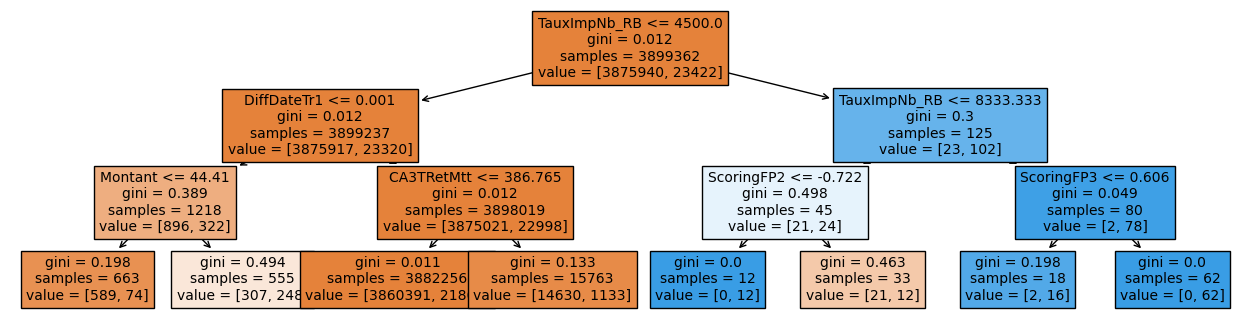

In [43]:
plt.figure(figsize=(16,4))
plot_tree(model_arbre,feature_names = list(X_train.columns),filled=True, fontsize=10)
plt.show()

Analyse des prédictions

In [47]:
Y_pred = model_arbre.predict(X_test)
Y_pred_proba = model_arbre.predict_proba(X_test)
from sklearn.metrics import confusion_matrix
mc = pd.DataFrame(confusion_matrix(Y_test,Y_pred), 
                  columns=['pred_0','pred_1'],
                  index=['obs_0','obs_1'])

mc

,pred_0,pred_1
obs_0,740833,5
obs_1,6563,10


In [48]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,Y_pred))

0.9912123316354723


In [50]:
from sklearn.metrics import f1_score
print('f1_score : ' + 
      str(f1_score(Y_test,Y_pred, average='macro')))

f1_score : 0.4993112691189521


## Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np

parameters = {'max_depth' : np.arange(start = 16, stop = 24, step = 1) , 
              'min_samples_leaf' : np.arange(start = 2, stop = 4, step = 1),
              'min_samples_split' : np.arange(start = 2, stop = 5, step = 1)}


In [57]:
modele_foret = RandomForestClassifier()
f1 = make_scorer(f1_score , average='macro')
modele_foret = GridSearchCV(modele_foret,
                                  parameters,
                                  scoring = f1,
                                  verbose = 2, 
                                  cv = 5)
modele_foret.fit(X_train, Y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END max_depth=16, min_samples_leaf=2, min_samples_split=2; total time=23.6min
[CV] END max_depth=16, min_samples_leaf=2, min_samples_split=2; total time=22.4min
[CV] END max_depth=16, min_samples_leaf=2, min_samples_split=2; total time=21.9min


KeyboardInterrupt: 